In [1]:
# @title Instalar librerias
from IPython.display import clear_output
# @markdown **ALERTA:** Puede haber alertas o errores, es mejor ignorarlos
# Import modules
!pip install --upgrade pip --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg
!pip install gym --quiet
!pip install enum34 --quiet
!pip install dm-env --quiet
!pip install pandas --quiet
!pip install grpcio==1.34.0 --quiet
!pip install tensorflow --quiet
!pip install typing --quiet
!pip install einops --quiet
!pip install dm-acme --quiet
!pip install dm-acme[reverb] --quiet
!pip install dm-acme[jax,tensorflow] --quiet
!pip install dm-acme[envs] --quiet
!pip install dm-env --quiet


import gym
import enum
import copy
import time
import acme
import torch
import base64
import dm_env
import IPython
import imageio
import warnings
import itertools
import collections

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt

from acme import specs
from acme import wrappers
from acme.utils import tree_utils
from acme.utils import loggers
from torch.autograd import Variable
from torch.distributions import Categorical
from typing import Callable, Sequence

warnings.filterwarnings('ignore')
np.set_printoptions(precision=3, suppress=1)

import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
mpl.rc('image', cmap='Blues')



     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 26.9 MB 1.5 MB/s            
     |████████████████████████████████| 3.9 MB 5.2 MB/s            
     |████████████████████████████████| 78 kB 3.4 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 309 kB 5.4 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 3.8 MB 39.0 MB/s            
     |████████████████████████████████| 65 kB 2.2 MB/s             
     |████████████████████████████████| 207 kB 11.0 MB/s            
     |████████████████████████████████| 126 kB 46.1 MB/s            
     |████████████████████████████████| 4.0 MB 47.6 MB/s            
     |████████████████████████████████| 6.4 MB 17.4 MB/s            
     |████████████████████████████████| 287 kB 41.4 MB/s            
     |████████████████████████████████| 112 kB 40.6 MB/s            
     |███████████████████████████████

In [2]:
# @title Funciones de ayuda para el resto de la libreta
# @markdown Funciones para visualización y ploteo

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]


def plotear_valores(valores, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(valores, interpolation="nearest",
             cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])


def plotear_estado_valor(valores_accion, epsilon=0.1):
  q = valores_accion
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(valores_accion)
  vmax = np.max(valores_accion)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plotear_valores(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plotear_valores_accion(valores_accion, epsilon=0.1):
  q = valores_accion
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(valores_accion)
  vmax = np.max(valores_accion)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, mapeo_accion_a_subplot(a))

    plotear_valores(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    nombre_accion = mapeo_accion_a_nombre(a)
    plt.title(r"$q(s, \mathrm{" + nombre_accion + r"})$")

  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plotear_valores(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plotear_estadisticas(estadisticas, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(estadisticas.episode_lengths), window)
  plt.plot(xline, smooth(estadisticas.episode_lengths, window=window))
  plt.ylabel('Longitud Episodio')
  plt.xlabel('Contador Episodio')
  plt.subplot(122)
  plt.plot(xline, smooth(estadisticas.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)

def configurar_dispositivo():
  dispositivo= "cuda" if torch.cuda.is_available() else "cpu"
  if dispositivo != "cuda":
    print("ALERTA: Para que pueda esta libreta pueda tener un comportamiento optimizado, "
        "se puede seleccionar en el menú `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU esta disponible en esta libreta")

  return dispositivo

In [3]:
# @title Asignar una seed para la repetibilidad de los procesos aleatorios
# @markdown Para poder comparar los datos aleatorios que se usaran, entre usuarios y sus resultados
import random
import torch

def asignar_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Seed aleatoria {seed} ha sido configurada.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
SEED = 2022
asignar_seed(seed=SEED)
DISPOSITIVO = configurar_dispositivo()

Seed aleatoria 2022 ha sido configurada.
GPU esta disponible en esta libreta


---
# Section 1: Procesos de decisión Markovianas

Casi todos los problemas de aprendizaje por refuerzo pueden ser conceptualizados como un problema Markoviano de decisión. ¿a que nos referimos con esto? una propiedad "Markoviana" que todos nuestros estados deben de tener es el hecho de que el futuro depende del estado actual no de toda la historia.

\begin{equation}
\mathbb{P}\left[ S(t+1) | S(t) \right] = \mathbb{P} \left[ S(t+1) |S1,..., S(t)\right]
\end{equation}

Que el futuro y el pasado con condicionalmente independientes según el presente, o que en el estado actual tenemos todo lo necesario para tomar una decisión futura.

Un proceso Markoviano tiene 5 elementos que son los siguientes:

1. $\color{red}{S} \$ - un set de estados
 
2. $\color{blue}{A} \$ - un set de acciones

3. $\color{yellow}{P} \$ -una función de probabilidad que determina la transición

4. $\color{green}{R} \$ -una función de recompensa 

5. $\gamma$ - un factor de descuento para las recompensas futuras

<br>
<center><img src="https://github.com/MiguelAdame98/Reinforcement/blob/main/Markov.jpg" width="500" /></center>

---
# Section 2: Bandidos con multiples brazos

---
# Section 1: Introducción a aprendizaje por refuerzo

The agent interacts with the environment in a loop corresponding to the following diagram. The environment defines a set of <font color='blue'>**actions**</font>  that an agent can take.  The agent takes an action informed by the <font color='redorange'>**observations**</font> it receives, and will get a <font color='green'>**reward**</font> from the environment after each action. The goal in RL is to find an agent whose actions maximize the total accumulation of rewards obtained from the environment. 

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D2_BasicReinforcementLearning/static/RL_loop.png" width="500" /></center>

For this practical session we will focus on a **simple grid world** environment,which consists of a 9 x 10 grid of either wall or empty cells, depicted in black and white, respectively. The smiling agent starts from an initial location and needs to navigate to reach the goal square.

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D2_BasicReinforcementLearning/static/tabular_RL_loop.png" width="500" /></center>

Below you will find an implementation of this Gridworld as a `dm_env.Environment`.

There is no coding in this section, but if you want, you can look over the provided code so that you can familiarize yourself with an example of how to set up a **grid world** environment.

In [22]:


class ObservationType(enum.IntEnum):
  STATE_INDEX = enum.auto()
  AGENT_ONEHOT = enum.auto()
  GRID = enum.auto()
  AGENT_GOAL_POS = enum.auto()


class GridWorld(dm_env.Environment):

  def __init__(self,
               layout,
               start_state,
               goal_state=None,
               observation_type=ObservationType.STATE_INDEX,
               discount=0.9,
               penalty_for_walls=-5,
               reward_goal=10,
               max_episode_length=None,
               randomize_goals=False):
    
    """ Se busca construir un ambiente llamado "GridWorld" con un mapa, un inicio y una meta

    El diseño es una cuadrícula NxN el valor si esta vacío sería de 0, -1 si es una pared,
     y cualquier valor positivo sería refuerzo..
    """
    if observation_type not in ObservationType:
      raise ValueError('observation_type should be a ObservationType instace.')
    self._layout = np.array(layout)
    self._start_state = start_state
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._reward_goal = reward_goal
    self._observation_type = observation_type
    self._layout_dims = self._layout.shape
    self._max_episode_length = max_episode_length
    self._num_episode_steps = 0
    self._randomize_goals = randomize_goals
    if goal_state is None:
      # Randomly sample goal_state if not provided
      goal_state = self._sample_goal()
    self.goal_state = goal_state

  def _sample_goal(self):
    """Randomly sample reachable non-starting state."""
    # Sample a new goal
    n = 0
    max_tries = 1e5
    while n < max_tries:
      goal_state = tuple(np.random.randint(d) for d in self._layout_dims)
      if goal_state != self._state and self._layout[goal_state] == 0:
        # Reachable state found!
        return goal_state
      n += 1
    raise ValueError('Failed to sample a goal state.')

  @property
  def layout(self):
    return self._layout
  @property
  def number_of_states(self):
    return self._number_of_states
  @property
  def goal_state(self):
    return self._goal_state
  @property
  def start_state(self):
    return self._start_state
  @property
  def state(self):
    return self._state
  def set_state(self, x, y):
    self._state = (y, x)
  @goal_state.setter
  def goal_state(self, new_goal):
    if new_goal == self._state or self._layout[new_goal] < 0:
      raise ValueError('no es valido')
    # Zero out any other goal
    self._layout[self._layout > 0] = 0
    # Setup new goal location
    self._layout[new_goal] = self._reward_goal
    self._goal_state = new_goal

  def observation_spec(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      return specs.Array(
          shape=self._layout_dims,
          dtype=np.float32,
          name='observation_agent_onehot')
    elif self._observation_type is ObservationType.GRID:
      return specs.Array(
          shape=self._layout_dims + (3,),
          dtype=np.float32,
          name='observation_grid')
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return specs.Array(
          shape=(4,), dtype=np.float32, name='observation_agent_goal_pos')
    elif self._observation_type is ObservationType.STATE_INDEX:
      return specs.DiscreteArray(
          self._number_of_states, dtype=int, name='observation_state_index')

  def action_spec(self):
    return specs.DiscreteArray(4, dtype=int, name='action')

  def get_obs(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      obs = np.zeros(self._layout.shape, dtype=np.float32)
      # Place agent
      obs[self._state] = 1
      return obs
    elif self._observation_type is ObservationType.GRID:
      obs = np.zeros(self._layout.shape + (3,), dtype=np.float32)
      obs[..., 0] = self._layout < 0
      obs[self._state[0], self._state[1], 1] = 1
      obs[self._goal_state[0], self._goal_state[1], 2] = 1
      return obs
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return np.array(self._state + self._goal_state, dtype=np.float32)
    elif self._observation_type is ObservationType.STATE_INDEX:
      y, x = self._state
      return y * self._layout.shape[1] + x

  def reset(self):
    self._state = self._start_state
    self._num_episode_steps = 0
    if self._randomize_goals:
      self.goal_state = self._sample_goal()
    return dm_env.TimeStep(
        step_type=dm_env.StepType.FIRST,
        reward=None,
        discount=None,
        observation=self.get_obs())

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError(
          'Invalid action: {} is not 0, 1, 2, or 3.'.format(action))

    new_y, new_x = new_state
    step_type = dm_env.StepType.MID
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
      step_type = dm_env.StepType.LAST

    self._state = new_state
    self._num_episode_steps += 1
    if (self._max_episode_length is not None and
        self._num_episode_steps >= self._max_episode_length):
      step_type = dm_env.StepType.LAST
    return dm_env.TimeStep(
        step_type=step_type,
        reward=np.float32(reward),
        discount=discount,
        observation=self.get_obs())

  def plot_grid(self, add_start=True):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout <= -1, interpolation='nearest')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    # Add start/goal
    if add_start:
      plt.text(
          self._start_state[1],
          self._start_state[0],
          r'$\mathbf{S}$',
          fontsize=16,
          ha='center',
          va='center')
    plt.text(
        self._goal_state[1],
        self._goal_state[0],
        r'$\mathbf{G}$',
        fontsize=16,
        ha='center',
        va='center')
    h, w = self._layout.shape
    for y in range(h - 1):
      plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-w', lw=2)
    for x in range(w - 1):
      plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-w', lw=2)

  def plot_state(self, return_rgb=False):
    self.plot_grid(add_start=False)
    # Add the agent location
    plt.text(
        self._state[1],
        self._state[0],
        u'😃',
        # fontname='symbola',
        fontsize=18,
        ha='center',
        va='center',
    )
    if return_rgb:
      fig = plt.gcf()
      plt.axis('tight')
      plt.subplots_adjust(0, 0, 1, 1, 0, 0)
      fig.canvas.draw()
      data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
      w, h = fig.canvas.get_width_height()
      data = data.reshape((h, w, 3))
      plt.close(fig)
      return data

  def plot_policy(self, policy):
    action_names = [
        r'$\uparrow$', r'$\rightarrow$', r'$\downarrow$', r'$\leftarrow$'
    ]
    self.plot_grid()
    plt.title('Policy Visualization')
    h, w = self._layout.shape
    for y in range(h):
      for x in range(w):
        # if ((y, x) != self._start_state) and ((y, x) != self._goal_state):
        if (y, x) != self._goal_state:
          action_name = action_names[policy[y, x]]
          plt.text(x, y, action_name, ha='center', va='center')

  def plot_greedy_policy(self, q):
    greedy_actions = np.argmax(q, axis=2)
    self.plot_policy(greedy_actions)


def build_gridworld_task(task,
                         discount=0.9,
                         penalty_for_walls=-5,
                         observation_type=ObservationType.STATE_INDEX,
                         max_episode_length=200):
  """Ya estamos construyendo un diseño de grid, con sus coordenadas de inicio 
     y una meta.

  """
  tasks_specifications = {
      'simple': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (7, 2)
      },
      'obstacle': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, -1, 0, 0, -1],
              [-1, 0, 0, 0, -1, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, -1, -1, -1],
              [-1, 0, 0, 0, 0, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, -1, -1, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (2, 8)
      },
      'random_goal': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          # 'randomize_goals': True
      },
  }
  return GridWorld(
      discount=discount,
      penalty_for_walls=penalty_for_walls,
      observation_type=observation_type,
      max_episode_length=max_episode_length,
      **tasks_specifications[task])


def setup_environment(environment):
  """Returns the environment and its spec."""

  # Make sure the environment outputs single-precision floats.
  environment = wrappers.SinglePrecisionWrapper(environment)

  # Grab the spec of the environment.
  environment_spec = specs.make_environment_spec(environment)

  return environment, environment_spec

Text(0.5, 1.0, 'Random')

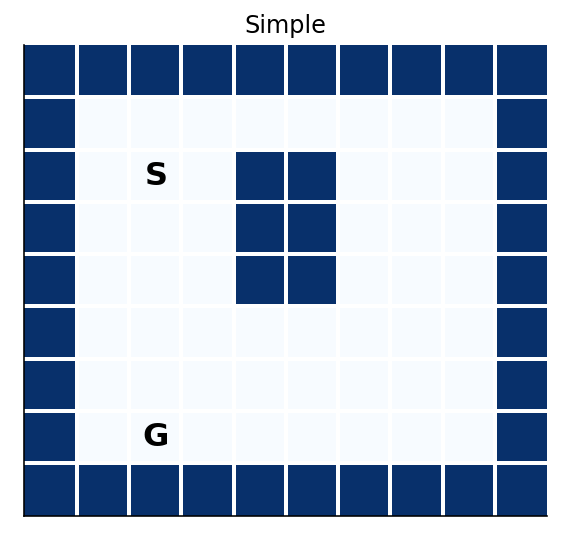

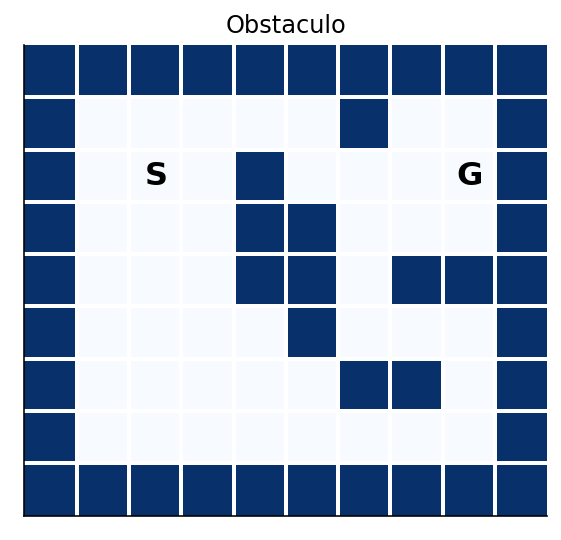

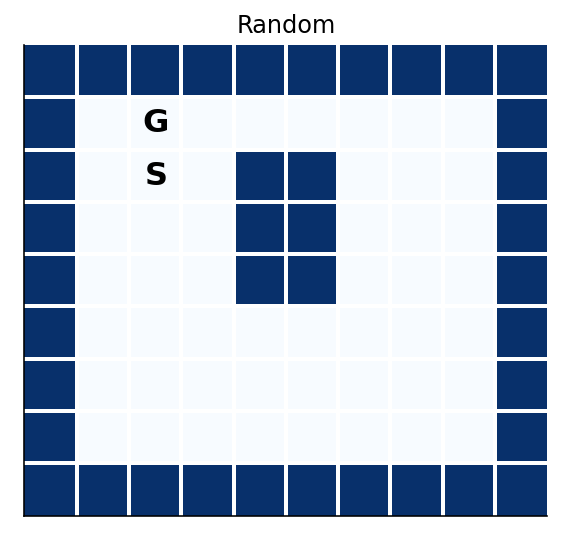

In [23]:
# Veamos los diferentes ambientes creados

simple_grid = build_gridworld_task(
    task='simple', observation_type=ObservationType.GRID)

obstacle_grid = build_gridworld_task(
    task='obstacle', observation_type=ObservationType.GRID)

random_goal_grid= build_gridworld_task(
    task='random_goal', observation_type=ObservationType.GRID)


simple_grid.plot_grid()
plt.title('Simple')

obstacle_grid.plot_grid()
plt.title('Obstaculo')


random_goal_grid.plot_grid()
plt.title('Random')